## TODO:

- # Only calibrate if using RF. Or add separate notebooks for explainability and performance..


- add decsription of data preprocessing/format and how to put user's own data into required format.
- add .gitignore for trained models, data files +....?

- the fimps (and performances?) presented in the paper are from: 'cap_rf_development.joblib'
-  rerun GridSearchCV with predefined splits, check output, then do manual k-fold fits to produce performance results (and ROCs) for each fold as requested by reviewer.

- cap_rf_gridsearch_090920_2.joblib giving different accruacy on train set: was 99.33, now 98.04%. (Caused by pickle mismatch?). ####Don't want to retrain RF because we wan't to keep exactly the same same wordclouds etc...Calibration plot also slightly different (Brier: 0.075 -> 0.071.)

- remove anything labelled "## temporary" (these are just to speed up things e.g. not have to preprocess the cap data each time)

- strengthen the explanation of use case. High-level of performance likely due to the training of reviewers and the specific way they use languae (although still distinct signatures). Understanding of the strucutre of the data (hard versus easy) is key to how this could be used. E.g. the easy cases could be semi-automated (measure fo uncertainty required), freeing up time for human decision makers to focus on the hard cases. This structure (of hard and easy decisions/predictions) is likely to extend to other domains. We will looks at e.g. ICU data (delerium? sleep?). Also semi-automation of producing the reviews from EHR. First would required our trained reviewers to have confidence in the system - evaluation phase. "information triage"

- Word clouds: we acknowledge that these are of limited use. They were useful at this stage for the reviewers to quickly inspect and compare different classifiers and to get an overview of how they are working. In future work we will need to deapen the reviewers intuition so that they can really understand how the classifier is working (and where it isn't working) so that they can some to trust it and to help improve it where necessary. This process will involve detailed case studies and we will employ more functions from FAT-Forensics, such as...However, such analyses were beyond the scope of this initial study. 

- comment on how performance (and more importantly generalisation) could be improved using state of the art methods and word embeddings trained on medical corpus - likely our model is overfitted

- Justify choice of random forest - most interpretable out of the box. But could use any classifier with LIME and SHAP and other FATF methods.

#### Configure script.

We set global variables that define behaviour of this script.

In [22]:
DATA_DIR = "../data/"   
DATA = "blum" #"CAP"
CLASS_LABEL = 'pca_death_code'  # Target label to predict

RANDOM_STATE = 42
TEST_SIZE = 0.2

CLASSIFIER = 'rf'
LOAD_CLASSIFIER = True
CLASSIFIER_FILENAME = 'cap_%s_gridsearch_230121_4".joblib' % CLASSIFIER # So far _4 is best for RF


# Specify the hyperparameters to optimise when training classifiers:
PARAMETERS = {
    'vect__ngram_range': ((1, 2),),
    'vect__max_df': (0.7,),
    'vect__min_df': (5,),
    'vect__max_features': (1500,),
}

if CLASSIFIER == "rf":    
    PARAMETERS['clf__n_estimators'] = (2000,) #(100, 500)
    #PARAMETERS['clf__max_features'] = (0.1,0.2,)
    #'PARAMETERS[clf__max_depth'] = (5,10,15)
    PARAMETERS['clf__max_depth'] = (10,15)
    PARAMETERS['clf__max_samples'] = (0.7,0.8,0.9)
    PARAMETERS['clf__min_samples_leaf'] = (3,4)
    #PARAMETERS['clf__n_estimators'] = (100,)
    #PARAMETERS['clf__max_samples'] = (0.8,)
    
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(random_state=RANDOM_STATE)

elif CLASSIFIER == 'lr':
    PARAMETERS['clf__C'] = (0.001, 0.01, 0.1, 1.0, 10.0, 100.0)
    PARAMETERS['clf__penalty'] = ('l1', 'l2', 'elasticnet', 'none')
    PARAMETERS['clf__fit_intercept'] = (True, False)
    
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=RANDOM_STATE)

elif CLASSIFIER == 'svc':
    PARAMETERS['clf__C'] = (0.001, 0.01, 0.1, 1.0, 10.0, 100.0)
    PARAMETERS['clf__kernel'] = ('linear', 'poly', 'sigmoid')
    PARAMETERS['clf__probability'] = (True, )
    
    from sklearn.svm import SVC
    model = SVC(random_state=RANDOM_STATE)
    

CV = 5
SCORING = None # Specify scoring metric to use for GridsearchCV (or use default if None)

In [23]:
import pandas as pd
from joblib import dump, load

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score

from cap_helper import *

from helper import (pd_print, 
                    accuracy,
                    lemmatize_text,
                    summarise_gridsearch_classifier,
                    calibrate_random_forest, 
                    plot_calibration_curve,
                    plot_calibration_curve_easy_hard,
                    plot_roc_curve,
                    compute_all_metrics)

from explainability import (get_rf_feature_importances,
                            wordcloud,
                            run_tree_interpreter,
                            get_ti_feature_contributions_for_instance_i,
                            get_ti_feature_contributions_average)

import matplotlib.pyplot as plt
%matplotlib inline

## temporary:
import pickle

In [24]:
if DATA == "CAP":
    
    print("Loading CAP prostate cancer data for preprocessing.")
    df = load_data(DATA_DIR)
    # Combine text from all feature columns into a single string column
    df = concatenate_feature_columns(df)
    # Link to dates of death:
    df = add_dates(df, DATA_DIR)
    # Link to reviewer Ids:
    df = add_reviewer_ids(df, DATA_DIR)
    # Convert all dates to be in units of months before/after death (Note: this regex is not foolproof)
    df = convert_dates_relative(df)  
    
    print("Preprocessing complete.")
    
    with open('temp_data.pickle', 'wb') as outfile:
        pickle.dump(df, outfile)
    
    
## Temporary:
else:
    with open('temp_data.pickle', 'rb') as infile:
        df = pickle.load(infile)    

In [25]:
# The reviews are dominated by three authors:
pd_print(get_reviewer_counts(df))

,number of reviews
vig_author,
1.0,890
2.0,7
3.0,636
4.0,80
5.0,712
6.0,54
7.0,3
8.0,78
9.0,2


#### Having loaded and pre-processed the data we can start to train classifiers:

In [13]:
stemmer = WordNetLemmatizer()

In [14]:
X,y = df.combined, df[CLASS_LABEL]

In [15]:
documents = lemmatize_text(X, stemmer)

In [16]:
print(len(y[y==1]))
print(len(y[y==2]))

1098
1512


In [17]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords.words('english'))),
    ('tfidf', TfidfTransformer()),
    ('clf', model)
])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(documents, 
                                                    df[CLASS_LABEL], 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

In [26]:
if LOAD_CLASSIFIER:
    clf = load('models/' + CLASSIFIER_FILENAME)
    
else:
    clf = GridSearchCV(pipeline, PARAMETERS, n_jobs=-1, verbose=1, cv=CV, scoring=SCORING)
    clf.fit(X_train, y_train)
    dump(clf, 'models/' + CLASSIFIER_FILENAME)

In [20]:
## temporary
accuracy(clf, X_train, y_train, name='Train');
accuracy(clf, X_test, y_test);

Train Accuracy: 94.40%
Test Accuracy: 91.57%


In [77]:
## temporary
accuracy(clf, X_train, y_train, name='Train');
accuracy(clf, X_test, y_test);

Train Accuracy: 97.80%
Test Accuracy: 91.76%


In [27]:
## temporary
accuracy(clf, X_train, y_train, name='Train');
accuracy(clf, X_test, y_test);

Train Accuracy: 97.80%
Test Accuracy: 91.76%


In [21]:
summarise_gridsearch_classifier(clf)

Best score: 0.919
Best parameters set:
	clf__C: 1.0
	clf__break_ties: False
	clf__cache_size: 200
	clf__class_weight: None
	clf__coef0: 0.0
	clf__decision_function_shape: 'ovr'
	clf__degree: 3
	clf__gamma: 'scale'
	clf__kernel: 'sigmoid'
	clf__max_iter: -1
	clf__probability: True
	clf__random_state: 42
	clf__shrinking: True
	clf__tol: 0.001
	clf__verbose: False
	tfidf__norm: 'l2'
	tfidf__smooth_idf: True
	tfidf__sublinear_tf: False
	tfidf__use_idf: True
	vect__analyzer: 'word'
	vect__binary: False
	vect__decode_error: 'strict'
	vect__dtype: <class 'numpy.int64'>
	vect__encoding: 'utf-8'
	vect__input: 'content'
	vect__lowercase: True
	vect__max_df: 0.7
	vect__max_features: 1500
	vect__min_df: 5
	vect__ngram_range: (1, 2)
	vect__preprocessor: None
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', '

Note: Change positive class label for LeDeR

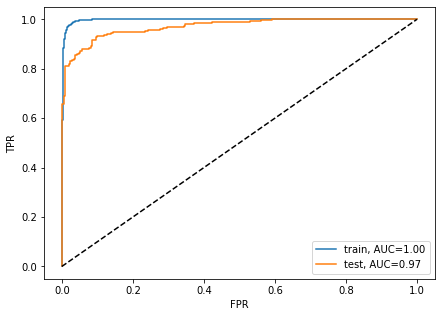

In [28]:
plot_roc_curve(clf, X_train, y_train, X_test, y_test, "train", "test", pos_label=2)

#### Calibration:

In [29]:
calibrated_clf = calibrate_random_forest(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.3s finished


Random forest:
	Brier: 0.080
	Precision: 0.892
	Recall: 0.905
	F1: 0.898

Random forest + Sigmoid:
	Brier: 0.068
	Precision: 0.870
	Recall: 0.895
	F1: 0.883



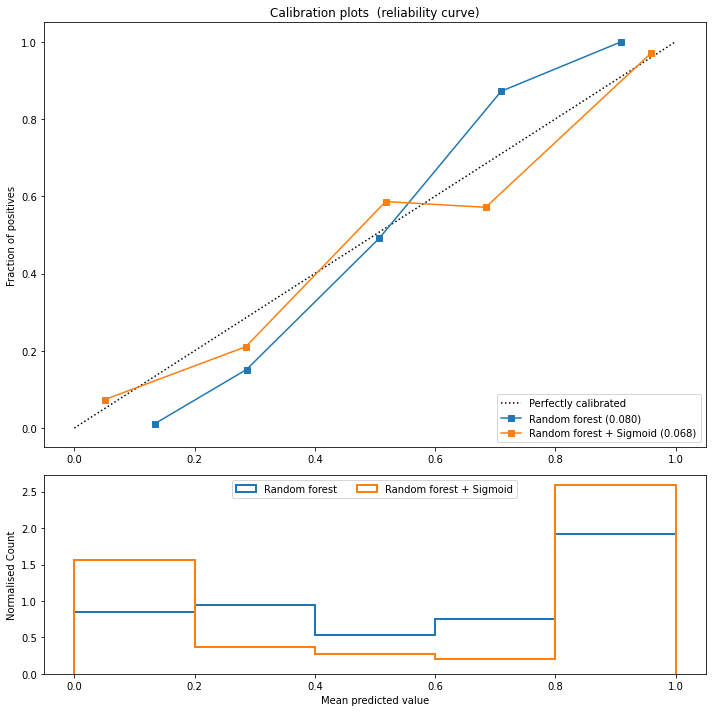

In [30]:
plot_calibration_curve(clf, calibrated_clf, X_test, y_test)

#### Stratify based on 'easy' and 'hard' cases:

Note: In CAP this is determined by the cause of death assignment route, essentially the harder it is to determine the cause of death the more levels of review and deliberartion are required.

easy cases:
	Brier: 0.045
	Precision: 0.937
	Recall: 0.922
	F1: 0.930

hard cases:
	Brier: 0.253
	Precision: 0.385
	Recall: 0.588
	F1: 0.465



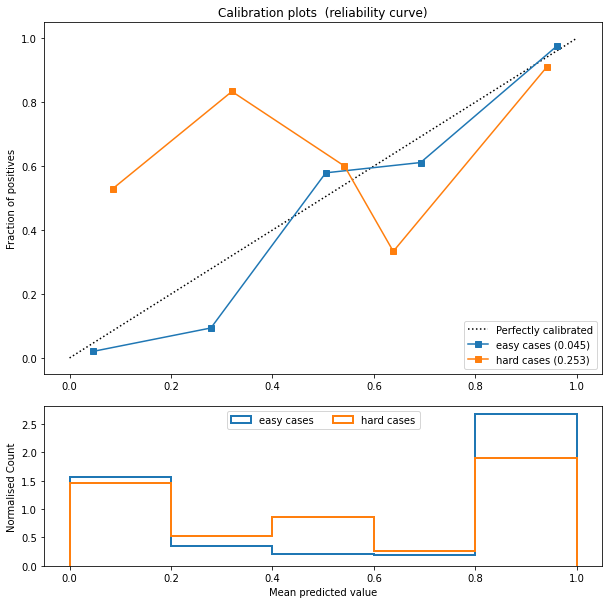

In [31]:
from cap_helper import get_easy_and_hard_cases
easy_x, hard_x, easy_y, hard_y = get_easy_and_hard_cases(df, subset_x=X_test, subset_y=y_test)
plot_calibration_curve_easy_hard(calibrated_clf, easy_x, hard_x, easy_y, hard_y)

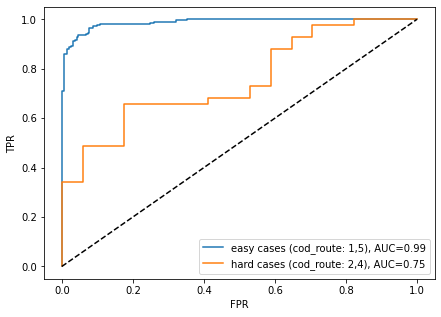

In [32]:
plot_roc_curve(clf, easy_x, easy_y, hard_x, hard_y, 'easy cases (cod_route: 1,5)', 'hard cases (cod_route: 2,4)', )

#### All metrics:

In [33]:
performance = compute_all_metrics(clf, X_train, y_train, X_test, y_test, 'train', 'test')
performance

TypeError: compute_all_metrics() takes 4 positional arguments but 7 were given

### To add (possibly):

 - ROC curves
 - tSNE of feature spcae

 
 ### Additional (maybe at end of script?):
 
 - Try to classify hard cases (show for SI)
 - produce authorship figures and anaylis for SI
 - produce list of text fields present in CAP and LeDeR (also get numbers for LeDeR table 1)

## Now for Explainability:

In [ ]:
fimps = get_rf_feature_importances(clf)
assert fimps.feature.is_unique
fimps.head(15)

In [21]:
fimps = get_rf_feature_importances(clf)
assert fimps.feature.is_unique
fimps.head(15)

,feature,contribution,magnitude
264,androgen,0.024975,0.024975
342,bone scan,0.023563,0.023563
528,docetaxel,0.019606,0.019606
1293,spine,0.018365,0.018365
1482,widespread,0.016851,0.016851
331,blockade,0.016139,0.016139
1222,sclerotic,0.015828,0.015828
375,casodex,0.015059,0.015059
913,metastasis,0.013687,0.013687
1212,scan,0.013265,0.013265


In [22]:
'nan' in list(fimps.feature)

False

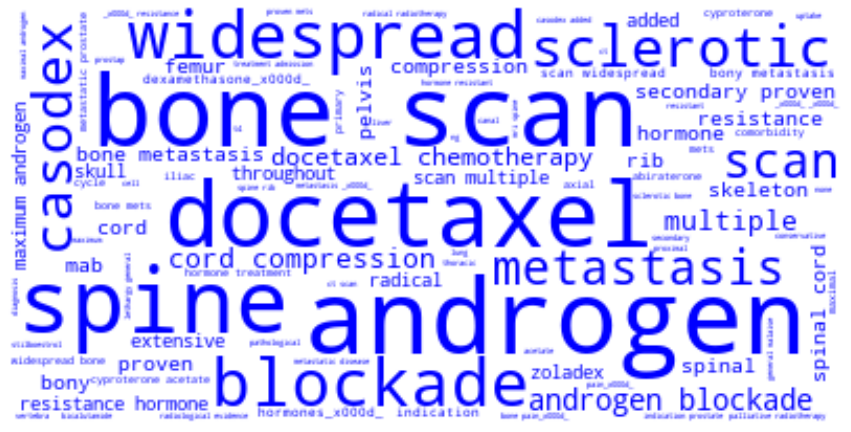

In [23]:
wordcloud(fimps)

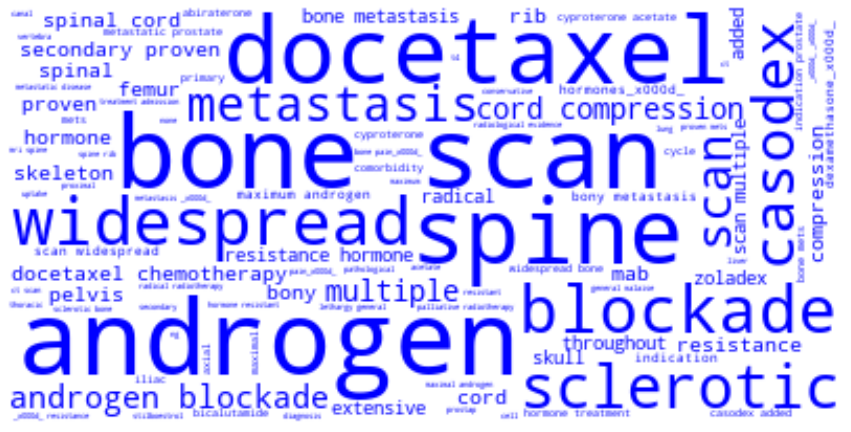

In [24]:
wordcloud(fimps)

# Use a different example!!

In [25]:
prediction, bias, contributions = run_tree_interpreter(clf, X_test)
ti_fimps_i = get_ti_feature_contributions_for_instance_i(3, contributions, clf)

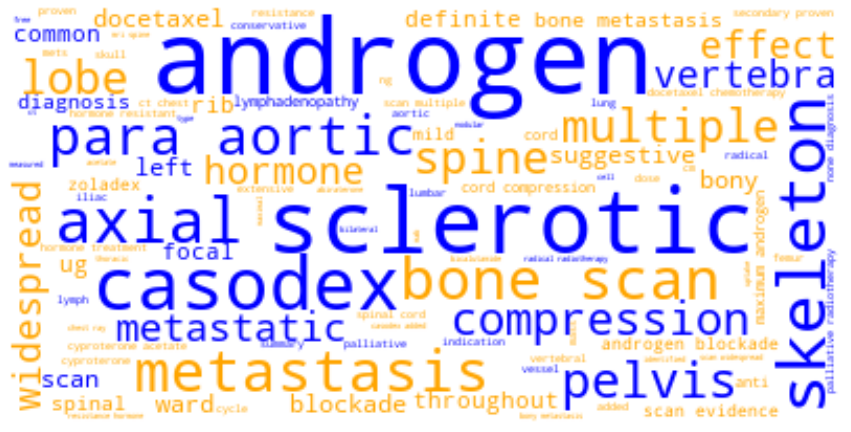

In [26]:
wordcloud(ti_fimps_i)

In [27]:
ti_fimps = get_ti_feature_contributions_average(contributions, clf)

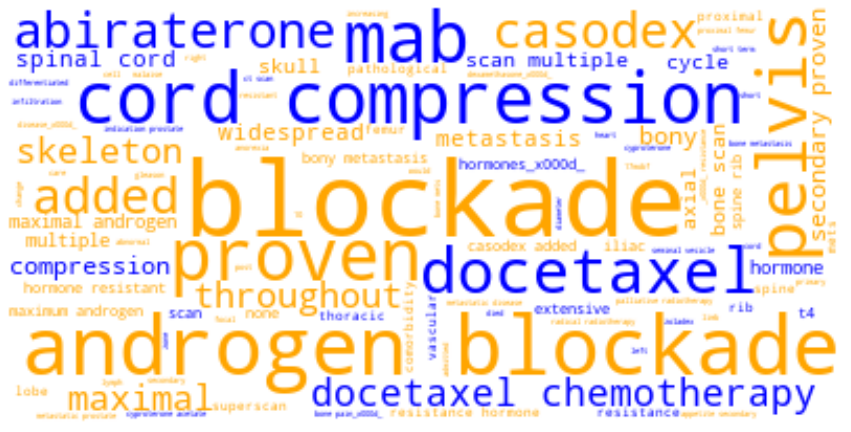

In [28]:
wordcloud(ti_fimps)

In [29]:
ti_fimps.sort_values('magnitude', ascending=False)

,feature,contribution,magnitude
331,blockade,-0.001891,0.001891
265,androgen blockade,-0.001343,0.001343
872,mab,0.000966,0.000966
451,cord compression,0.000946,0.000946
1125,proven,-0.000928,0.000928
...,...,...,...
58,19,0.000000,0.000000
164,67mobf,0.000000,0.000000
171,_x000d_ 10,0.000000,0.000000
20,10 07,0.000000,0.000000


## To add:

* LIME from FATF
* make notes on word clouds e.g. what do the colours represent etc

In [30]:
original_data = df.loc[y_test.index[86]]

In [31]:
feature_columns = df.columns[2:27]

In [32]:
from interpretable_pdf import InterpretablePDF

In [33]:
ipdf = InterpretablePDF(clf, X_test, y_test, feature_columns)

In [34]:
ipdf.create_pdf(86, original_data, "test.pdf")

In [35]:
fimp = ti_fimps.loc[ti_fimps.contribution < 0]

In [36]:
fimp

,feature,contribution,magnitude
0,01,-0.000031,0.000031
6,06,-0.000004,0.000004
11,08 _x000d_,-0.000032,0.000032
14,09 _x000d_,-0.000008,0.000008
17,0mobf ct,-0.000006,0.000006
...,...,...,...
1489,within left,-0.000029,0.000029
1491,without,-0.000024,0.000024
1493,would,-0.000238,0.000238
1496,zoladex _x000d_,-0.000003,0.000003


## TO DO:

* refactor InterpeetablePDF code
* see todo list in: replacing_dates_and_cleaning_pdf_output
* prdouce some example pdfs for publication (and visualise the head of them here)